In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import h5py
import cupy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from dotmap import DotMap

In [4]:
PROJECT_PATH = '../'
DATA_DIR = "/home/swei20/AE/data/"
PCA_PATH = '/scratch/ceph/dobos/data/pfsspec/import/stellar/rbf/bosz_5000_full/pca/spectra.h5'
NORM_PATH = "/scratch/ceph/szalay/swei20/AE/norm_flux_step4.h5"
sys.path.insert(0, PROJECT_PATH)

In [5]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Load data

In [5]:
with h5py.File(NORM_PATH, 'r') as f:
    flux0 = f['flux'][()]
    para0 = f['para'][()]
    wave0 = f['wave'][()]

In [6]:
flux0.shape, wave0.shape

((116614, 3850), (3850,))

In [7]:
from lv.base.dataloader import DataLoader

In [113]:
ds = DataLoader()

### Testing Cupy speed

In [114]:
ds.prepare_data(flux0, wave0, "H", "H", fix_CO=0, para=para0, center=0)

center 0 HH0 flux: 80442, wave: 1214


In [57]:
Mc= cp.asarray(ds.flux, dtype=cp.float32)

In [15]:
%timeit cp.linalg.svd(Mc, full_matrices=False)

396 ms ± 16.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit np.linalg.svd(M, full_matrices=False)

7.48 s ± 284 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit ds._svd(M, rank=100, tol=1e-6)

5.96 s ± 820 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Using cupy for pcp since it's much faster

In [40]:
from lv.pcp.pcpc import pcp_cupy

In [41]:
L, S, (u,s,v) = pcp_cupy(Mc, delta=1e-5, mu=11, lam = 0.0035, maxiter=500)

11 0.0035 320797.8


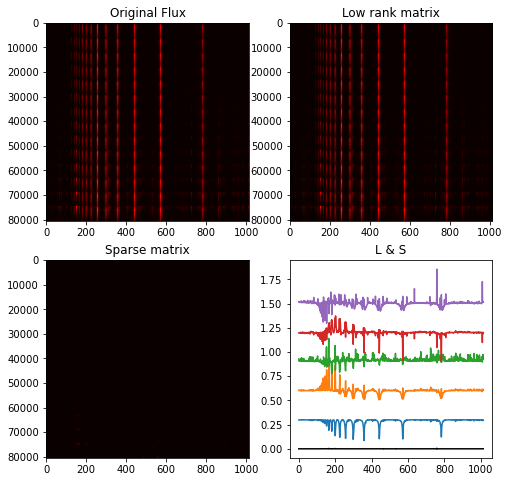

In [50]:
ds.plot_pcp(cp.asnumpy(Mc), L,S, u,s,v)

### generating mask

In [144]:
from lv.base.mask import get_mask, plot_SL

In [149]:
Mc= cp.asarray(ds.flux, dtype=cp.float32)

In [150]:
Mc.shape

(80442, 1214)

In [151]:
u,w,v = cp.linalg.svd(Mc, full_matrices=0)

In [152]:
vn = cp.asnumpy(v)

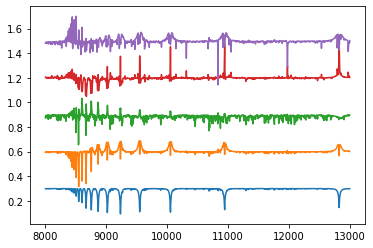

In [153]:
for i in range(min(len(v),5)):
    plt.plot(ds.wave, vn[i] + 0.3*(1 + i))
#     plt.plot(self.wave, np.mean(np.abs(S), axis=0), c="k")

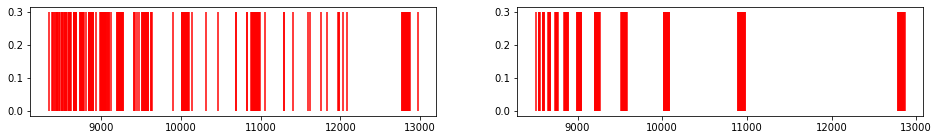

In [156]:
mask = get_mask(v, ds, k=5,q=0.8,step=2)

### plot S

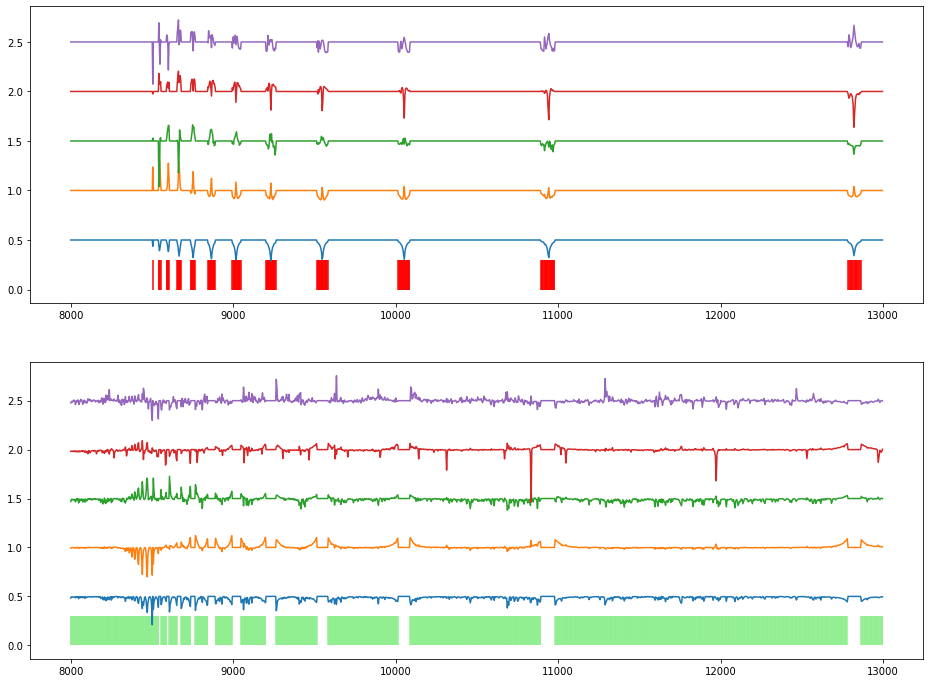

In [161]:
plot_SL(ds, mask, Mc)


### q = 0.6

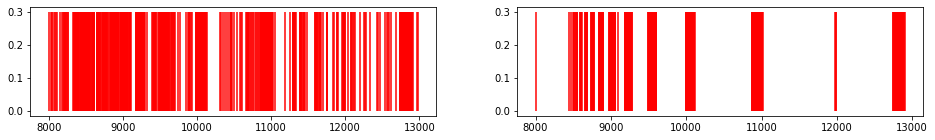

In [162]:
mask = get_mask(v, ds, k=5,q=0.6,step=2)

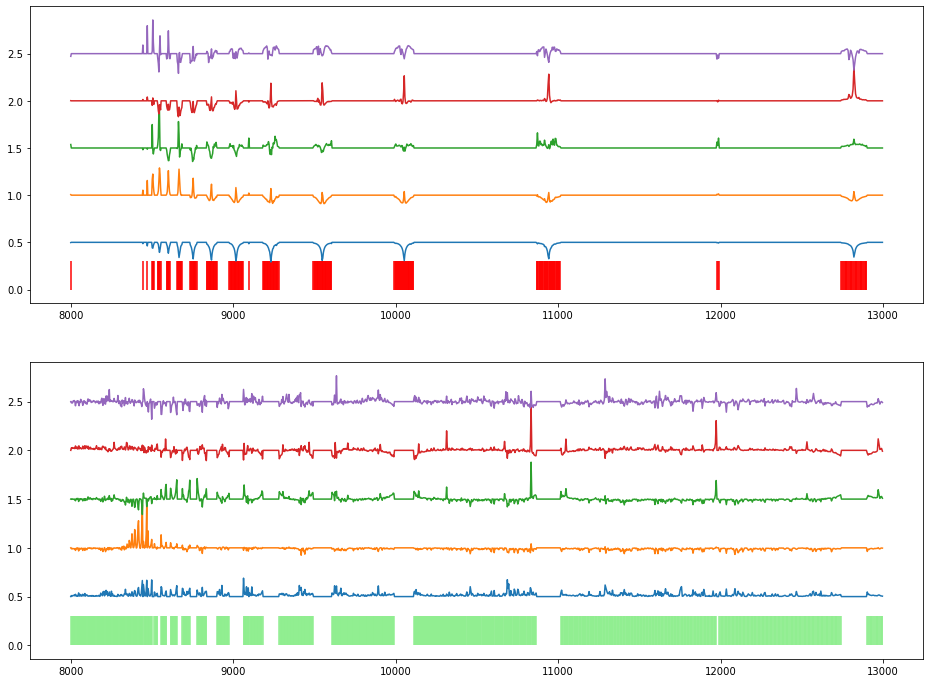

In [163]:
plot_SL(ds, mask, Mc)